# Computer Networks - TCP Congestion Control 
### Zhivar Sourati - 810196502
### Mohsen Fayyaz - 810196650

<ul>
    <li><b>سلام</b><br>
        <ul>
            <li>
                <b>Initial State:</b> map read from the file
            </li>
            <li>
                <b>Goal State:</b> a map which doesn't contain any numbers in it i.e. 1,2 or 3.
            </li>
            <li>
                <b>actions:</b> There are 8 different possible actions in any state which are moving P or Q one block to one of the four cardinal directions. (The move might not be possible due to colliding with walls or etc.)
            </li>
        </ul>
    </li>
</ul>

# CWND)



# Goodput)

# Packet Loss)



# RTT:

You chose TCP/Vegas
1->2 variable delay: 10
3->5 variable delay: 17
final ack0: 8332, final seq num0: 8336
final ack1: 4165, final seq num1: 4167

plotting...


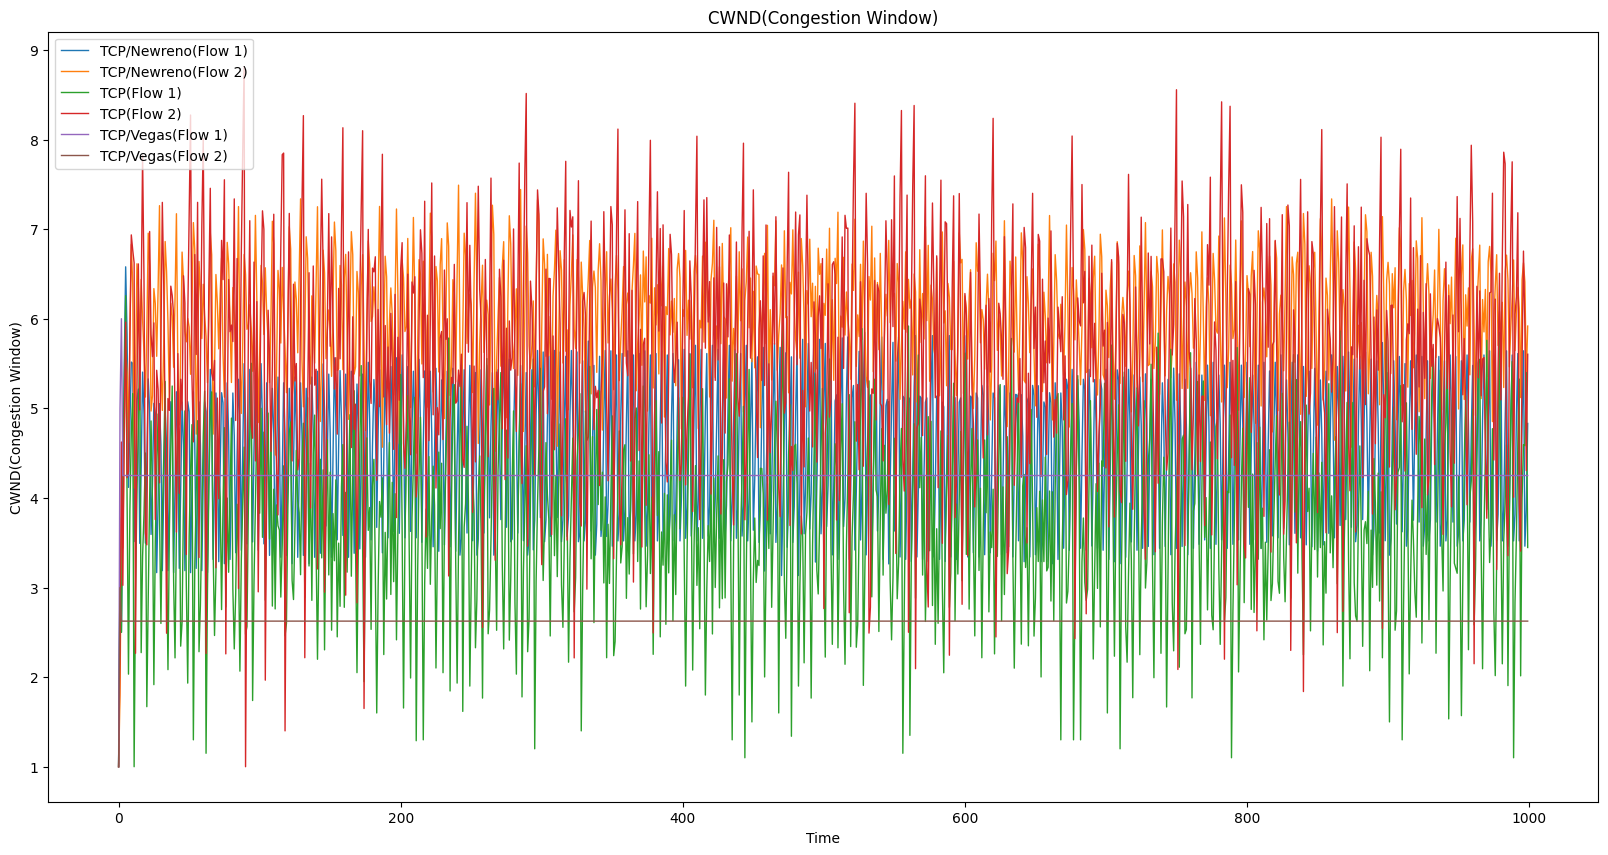

plotting...


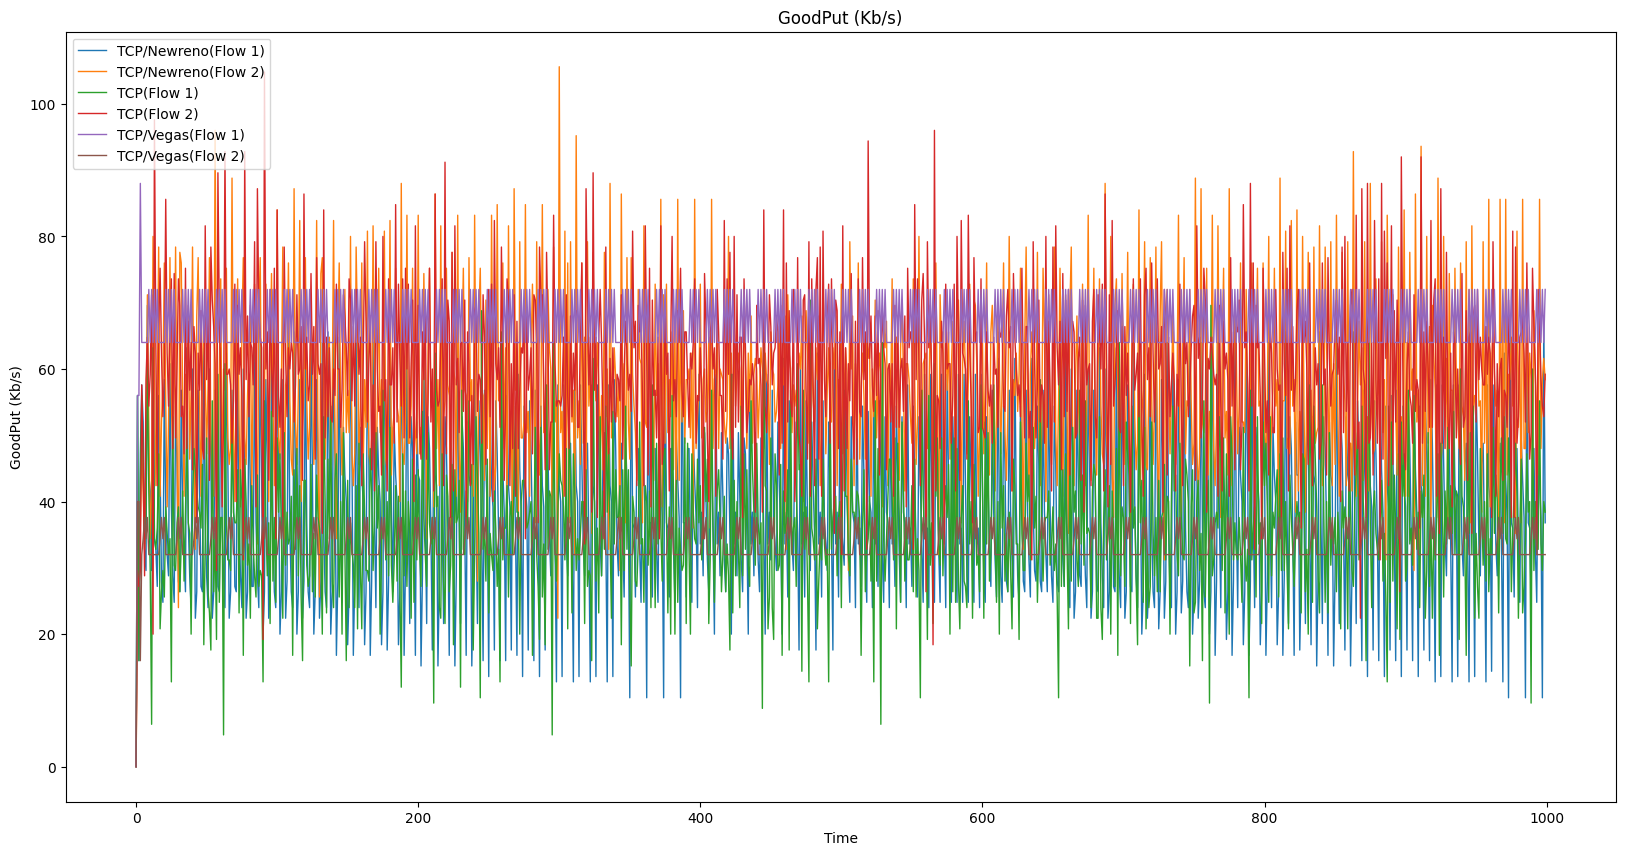

In [47]:
import os
import matplotlib.pyplot as plt
from os import system, name
import sys
from IPython.display import clear_output
import pandas as pd

# import jtplot module in notebook
from jupyterthemes import jtplot
# jtplot.style(context='talk', fscale=1.4, spines=True, gridlines='--')
jtplot.reset()

TCP_ALGORITHMS = ["TCP/Newreno", "TCP", "TCP/Vegas"]

def cls():
    # for windows
    if name == 'nt':
        _ = system('cls')

        # for mac and linux(here, os.name is 'posix')
    else:
        _ = system('clear')

    clear_output(wait=True)
    
    
def shrinkLargeList(myList, newSize = 200):
    # more then 100000 points makes it unusable slow to plot
    step = int(len(myList) / newSize)
    if(step == 0):
        step = 1
    return myList[0::step]
    
    
def graphFlows(inPlt, cwndChanges, label="No Label", title="No Title"):
#     cwndChanges = shrinkLargeList(cwndChanges)
    timeList = cwndChanges[["time"]]
    tcp0Cwnd = cwndChanges[["tcp0"]]
    tcp1Cwnd = cwndChanges[["tcp1"]]
#     print(timeList)
#     print(tcp0Cwnd)
#     print(tcp1Cwnd)
#     plt.plot(timeList, tcp0Cwnd, '-o', label=label + "(Flow 1)", linewidth=2)
#     plt.plot(timeList, tcp1Cwnd, '-o', label=label + "(Flow 2)", linewidth=2)
    inPlt.plot(timeList, tcp0Cwnd, label=label + "(Flow 1)", linewidth=1)
    inPlt.plot(timeList, tcp1Cwnd, label=label + "(Flow 2)", linewidth=1)
    
    inPlt.set_title(title)
    inPlt.set(xlabel='Time', ylabel=title)
#     inPlt.mset(xlabel='Time', ylabel=title)
#     plt.set_xlabel("Time")
#     plt.set_ylabel(title)
    inPlt.legend(loc="upper left")

#     plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
#     plt.gca().set_xticks(plt.gca().get_xticks()[::5])
#     plt.gca().set_yticks(plt.gca().get_yticks()[::10])
    
    
def retrieveCwndChanges(fileAddress):
    cwndChanges = list()
    with open(fileAddress, "r") as traceFile:
        for line in traceFile:
            lineWords = ' '.join(line.split()).strip().split(" ")
            cwndChanges.append([float(lineWords[0]), float(lineWords[1]), float(lineWords[2])])
    return cwndChanges


def runNs(tcpAlgorithm):
    print("Loading...")
    os.system('ns main.tcl ' + tcpAlgorithm + ' > tmp')
    cls()
    print(open('tmp', 'r').read())
    os.remove('tmp')

    
def plotResults(results, title):
    fig = plt.figure(figsize=(20, 10))
    for tcpAlgorithm in TCP_ALGORITHMS:
        graphFlows(plt.gca(), results[tcpAlgorithm], label=tcpAlgorithm, title=title)
    
    print("plotting...")
    plt.show()
    
    
def main():
#     TCP is Tahoe
    cwndResults = dict()
    goodPutResults = dict()
    rttResults = dict()
    
    for tcpAlgorithm in TCP_ALGORITHMS:
        for i in range(0, 10):
            runNs(tcpAlgorithm)
            newCwndDF = pd.DataFrame(retrieveCwndChanges("output/cwnd.out"), columns=['time','tcp0','tcp1'])
            newGoodPutDF = pd.DataFrame(retrieveCwndChanges("output/gp.out"), columns=['time','tcp0','tcp1'])
            if(i == 0):
                cwndDF = newCwndDF
                goodPutDF = newGoodPutDF
            else:
                cwndDF = cwndDF.add(newCwndDF, fill_value=0)
                goodPutDF = goodPutDF.add(newGoodPutDF, fill_value=0)
            
        cwndResults[tcpAlgorithm] = cwndDF / 10
        goodPutResults[tcpAlgorithm] = goodPutDF / 10
    
    plotResults(cwndResults, "CWND(Congestion Window)")
    plotResults(goodPutResults, "GoodPut (Kb/s)")
    
    
    
    
#     with open('test3', 'r') as file:
#         pac_map = file.read().splitlines()

#     characterized_map = list()
#     for line in pac_map:
#         characterized_map.append(list(line))


main()

<table style="width:100%;">
    <tr></tr>
    <tr>
        <td>
            <table style="width:100%; border: 1px solid #ddd;">
                <thead>
                    <tr>
                        <th style="text-align: center;">TEST #1</th>
                    </tr>
                <tr>
                    <th style="text-align: center;">Algorithm</th>
                    <th style="text-align: center;">Goal Depth</th>
                    <th style="text-align: center;">Explored States</th>
                    <th style="text-align: center;">Unique Explored States</th>
                    <th style="text-align: center;">Execution Time</th>
                </tr>
                </thead>
                <tr>
                    <td style="text-align: center;"><b>BFS</b></td>         
                    <td style="text-align: center;">34</td>
                    <td style="text-align: center;">133595</td>
                    <td style="text-align: center;">133595</td>
                    <td style="text-align: center;">92.904s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>IDS</b></td>        
                    <td style="text-align: center;">34</td>
                    <td style="text-align: center;">10045731</td>
                    <td style="text-align: center;">157883</td>
                    <td style="text-align: center;">858.272s</td>
                </tr>        
                <tr>
                    <td style="text-align: center;"><b>A*</b></td>         
                    <td style="text-align: center;">34</td>
                    <td style="text-align: center;">159809</td>
                    <td style="text-align: center;">67759</td>
                    <td style="text-align: center;">51.218s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>A*(#fruits)</b></td>         
                    <td style="text-align: center;">34</td>
                    <td style="text-align: center;">282783</td>
                    <td style="text-align: center;">118478</td>
                    <td style="text-align: center;">85.964s</td>
                </tr>
            </table>
        </td>
        <td>
            <table style="width:100%; border: 1px solid #ddd;">
                <thead>
                    <tr>
                        <th style="text-align: center;">TEST #2</th>
                    </tr>
                <tr>
                    <th style="text-align: center;">Algorithm</th>
                    <th style="text-align: center;">Goal Depth</th>
                    <th style="text-align: center;">Explored States</th>
                    <th style="text-align: center;">Unique Explored States</th>
                    <th style="text-align: center;">Execution Time</th>
                </tr>
                </thead>
                <tr>
                    <td style="text-align: center;"><b>BFS</b></td>         
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">2700</td>
                    <td style="text-align: center;">2700</td>
                    <td style="text-align: center;">0.944s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>IDS</b></td>        
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">132723</td>
                    <td style="text-align: center;">4146</td>
                    <td style="text-align: center;">5.961s</td>
                </tr>        
                <tr>
                    <td style="text-align: center;"><b>A*</b></td>         
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">4084</td>
                    <td style="text-align: center;">1805</td>
                    <td style="text-align: center;">0.789s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>A*(#fruits)</b></td>         
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">5811</td>
                    <td style="text-align: center;">2500</td>
                    <td style="text-align: center;">0.967s</td>
                </tr>
            </table>
        </td>
        <td>
            <table style="width:100%; border: 1px solid #ddd;">
                <thead>
                    <tr>
                        <th style="text-align: center;">TEST #3</th>
                    </tr>
                <tr>
                    <th style="text-align: center;">Algorithm</th>
                    <th style="text-align: center;">Goal Depth</th>
                    <th style="text-align: center;">Explored States</th>
                    <th style="text-align: center;">Unique Explored States</th>
                    <th style="text-align: center;">Execution Time</th>
                </tr>
                </thead>
                <tr>
                    <td style="text-align: center;"><b>BFS</b></td>         
                    <td style="text-align: center;">21</td>
                    <td style="text-align: center;">2372</td>
                    <td style="text-align: center;">2372</td>
                    <td style="text-align: center;">2.286s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>IDS</b></td>        
                    <td style="text-align: center;">21</td>
                    <td style="text-align: center;">133310</td>
                    <td style="text-align: center;">3017</td>
                    <td style="text-align: center;">14.221s</td>
                </tr>        
                <tr>
                    <td style="text-align: center;"><b>A*</b></td>         
                    <td style="text-align: center;">21</td>
                    <td style="text-align: center;">2030</td>
                    <td style="text-align: center;">1005</td>
                    <td style="text-align: center;">0.840s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>A*(#fruits)</b></td>         
                    <td style="text-align: center;">21</td>
                    <td style="text-align: center;">4521</td>
                    <td style="text-align: center;">2161</td>
                    <td style="text-align: center;">2.035s</td>
                </tr>
            </table>
        </td>
    </tr>
    <tr></tr>
    <tr>
        <td>
            <table style="width:100%; border: 1px solid #ddd;">
                <thead>
                    <tr>
                        <th style="text-align: center;">TEST #4</th>
                    </tr>
                <tr>
                    <th style="text-align: center;">Algorithm</th>
                    <th style="text-align: center;">Goal Depth</th>
                    <th style="text-align: center;">Explored States</th>
                    <th style="text-align: center;">Unique Explored States</th>
                    <th style="text-align: center;">Execution Time</th>
                </tr>
                </thead>
                <tr>
                    <td style="text-align: center;"><b>BFS</b></td>         
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">9319</td>
                    <td style="text-align: center;">9319</td>
                    <td style="text-align: center;">16.311s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>IDS</b></td>        
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">384043</td>
                    <td style="text-align: center;">14552</td>
                    <td style="text-align: center;">87.921s</td>
                </tr>        
                <tr>
                    <td style="text-align: center;"><b>A*</b></td>         
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">2942</td>
                    <td style="text-align: center;">1217</td>
                    <td style="text-align: center;">2.245s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>A*(#fruits)</b></td>         
                    <td style="text-align: center;">18</td>
                    <td style="text-align: center;">17301</td>
                    <td style="text-align: center;">6994</td>
                    <td style="text-align: center;">12.371s</td>
                </tr>
            </table>
        </td>
        <td>
            <table style="width:100%; border: 1px solid #ddd;">
                <thead>
                    <tr>
                        <th style="text-align: center;">TEST #5</th>
                    </tr>
                <tr>
                    <th style="text-align: center;">Algorithm</th>
                    <th style="text-align: center;">Goal Depth</th>
                    <th style="text-align: center;">Explored States</th>
                    <th style="text-align: center;">Unique Explored States</th>
                    <th style="text-align: center;">Execution Time</th>
                </tr>
                </thead>
                <tr>
                    <td style="text-align: center;"><b>BFS</b></td>         
                    <td style="text-align: center;">14</td>
                    <td style="text-align: center;">255</td>
                    <td style="text-align: center;">255</td>
                    <td style="text-align: center;">0.106s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>IDS</b></td>        
                    <td style="text-align: center;">14</td>
                    <td style="text-align: center;">10724</td>
                    <td style="text-align: center;">470</td>
                    <td style="text-align: center;">0.477s</td>
                </tr>        
                <tr>
                    <td style="text-align: center;"><b>A*</b></td>         
                    <td style="text-align: center;">14</td>
                    <td style="text-align: center;">151</td>
                    <td style="text-align: center;">84</td>
                    <td style="text-align: center;">0.038s</td>
                </tr>
                <tr>
                    <td style="text-align: center;"><b>A*(#fruits)</b></td>         
                    <td style="text-align: center;">14</td>
                    <td style="text-align: center;">374</td>
                    <td style="text-align: center;">197</td>
                    <td style="text-align: center;">0.076s</td>
                </tr>
            </table>
        </td>
    </tr>
</table>

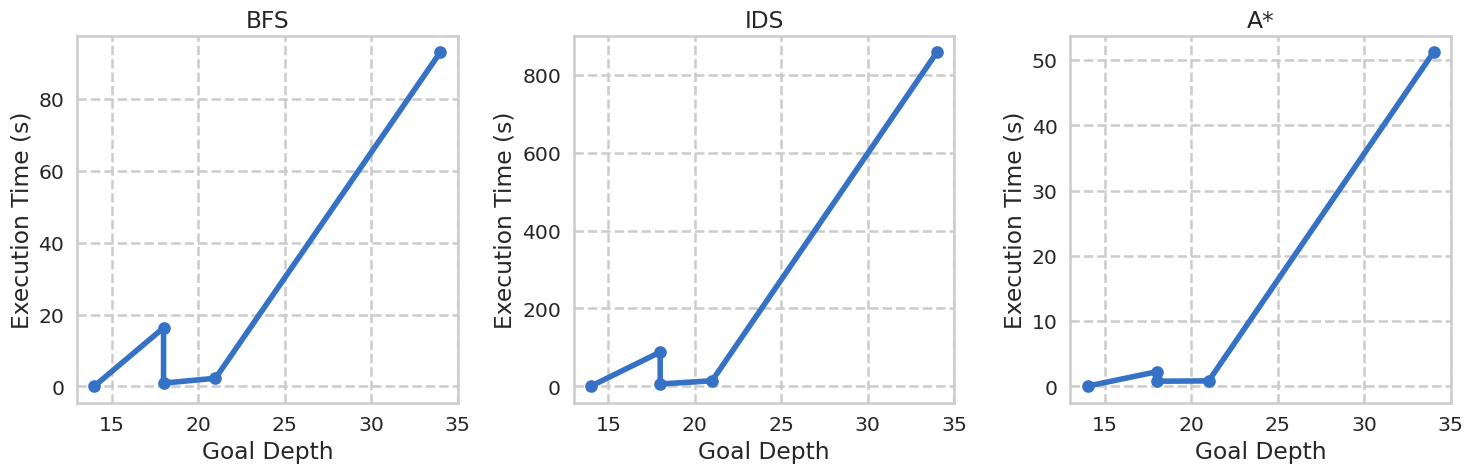

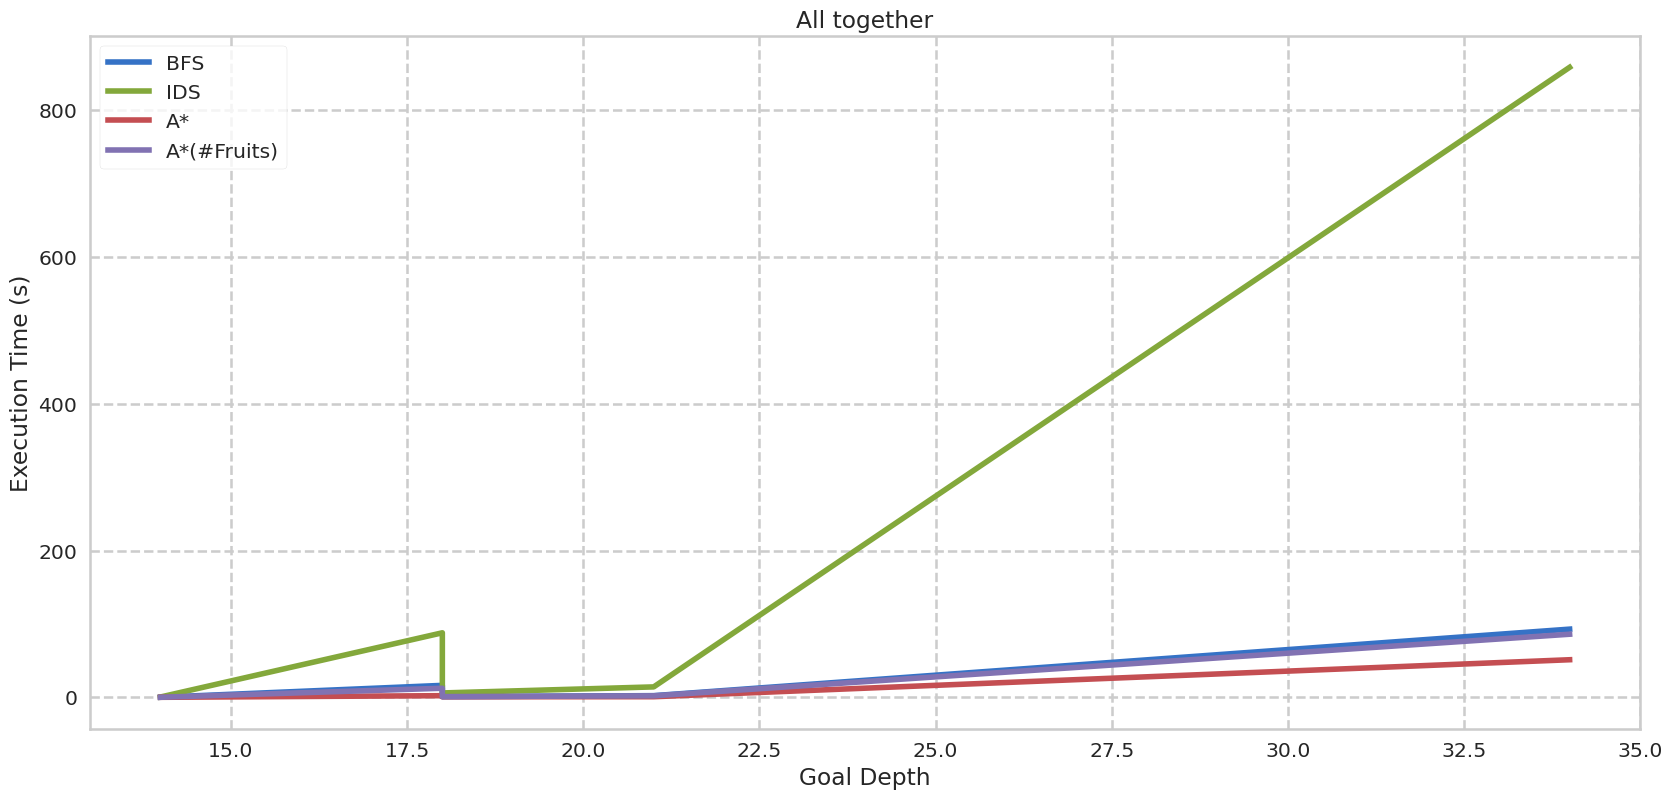

In [5]:
import matplotlib.pyplot as plt

# import jtplot module in notebook
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=True, gridlines='--')
# jtplot.reset()

# 5 - 4 - 2 - 3 - 1
depths = [14, 18, 18, 21, 34]
BFS_times = [0.106, 16.311, 0.944, 2.286, 92.904]
IDS_times = [0.477, 87.921, 5.961, 14.221, 858.272]
A_times = [0.038, 2.245, 0.789, 0.840, 51.218]
A_fruits_times = [0.076, 12.371, 0.967, 2.035, 85.964]
line_width = 4

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(depths, BFS_times, s=10)
plt.plot(depths, BFS_times, '-o', linewidth=line_width)
plt.title("BFS")
plt.xlabel("Goal Depth")
plt.ylabel("Execution Time (s)")

plt.subplot(1, 3, 2)
plt.scatter(depths, IDS_times, s=10)
plt.plot(depths, IDS_times, '-o', linewidth=line_width)
plt.title("IDS")
plt.xlabel("Goal Depth")
plt.ylabel("Execution Time (s)")

plt.subplot(1, 3, 3)
plt.scatter(depths, A_times, s=10)
plt.plot(depths, A_times, '-o', linewidth=line_width)
plt.title("A*")
plt.xlabel("Goal Depth")
plt.ylabel("Execution Time (s)")

plt.tight_layout()        
plt.show()

plt.figure(figsize=(20, 9))
plt.plot(depths, BFS_times, label="BFS", linewidth=line_width)
plt.plot(depths, IDS_times, label="IDS", linewidth=line_width)
plt.plot(depths, A_times, label="A*", linewidth=line_width)
plt.plot(depths, A_fruits_times, label="A*(#Fruits)", linewidth=line_width)
plt.title("All together")
plt.xlabel("Goal Depth")
plt.ylabel("Execution Time (s)")
plt.legend(loc="upper left")
plt.show()

Sources:

https://www.isi.edu/nsnam/ns/doc/node387.html

    Agent/TCP - a ``tahoe'' TCP sender
    Agent/TCP/Reno - a ``Reno'' TCP sender
    Agent/TCP/Newreno - Reno with a modification
    Agent/TCP/Sack1 - TCP with selective repeat (follows RFC2018)
    Agent/TCP/Vegas - TCP Vegas
    Agent/TCP/Fack - Reno TCP with ``forward acknowledgment''
    Agent/TCP/Linux - a TCP sender with SACK support that runs TCP congestion control modules from Linux kernel

